In [1]:
import pandas as pd

df_votes = pd.read_csv('spiders_votes.csv')

df_smartvote = pd.read_csv('spiders_smartvote.csv')

df_smartvote = df_smartvote[df_smartvote[['first_name', 'last_name']].apply(tuple, axis=1).isin(df_votes[['first_name', 'last_name']].apply(tuple, axis=1))]

df_questions_weight = pd.read_csv("smartvote_spider_question_weights.csv").fillna(0)

df_smartvote['sv_id'] = df_smartvote.apply(
    lambda x: df_votes.loc[
        (df_votes['first_name'] == x['first_name']) & (df_votes['last_name'] == x['last_name']), 'id'
    ].values[0],
    axis=1
)


sv_categories = ["offene_aussenpolitik", "liberale_wirtschaftspolitik", "restriktive_finanzpolitik", "law_and_order", "restriktive_migrationspolitik", "ausgebauter_umweltschutz", "ausgebauter_sozialstaat", "liberale_gesellschaft"]
prettier_labels = [" ".join([y.capitalize() for y in x.replace("and", "&").split("_")]) for x in sv_categories]



In [2]:
import torch
import torch.nn as nn
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            #Maybe try layer norm here and after bottleneck?
            nn.Linear(input_dim, 48),
            nn.GELU(),
            nn.LazyLinear(24),
            nn.GELU(),
            nn.LazyLinear(encoding_dim),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 24),
            nn.GELU(),
            nn.LazyLinear(48),
            nn.GELU(),
            nn.LazyLinear(input_dim),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [3]:
model = AutoEncoder(58,4)
model.load_state_dict(torch.load("neural_net_1.pt"))

<All keys matched successfully>

In [4]:
spider_selector = ["0", "1", "2", "3"]
votes = torch.tensor(df_votes[spider_selector].values, dtype=torch.float32)
smartvote = torch.tensor(df_smartvote[spider_selector].values, dtype=torch.float32)

In [5]:
def to_smartvote_spider(spider4 : torch.tensor):
    pred_answers = model.decoder(spider4)
    sv_spider_tensor = torch.zeros(8, 171)
    for i, sv_category in enumerate(sv_categories):
        sv_spider_tensor[i] = (torch.tensor(df_questions_weight[sv_category]) * pred_answers).sum(axis=-1)
        
    return sv_spider_tensor

to_smartvote_spider(votes)[0].shape

torch.Size([171])

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_two_spider_charts(data1, data2, title):
    data1 = list(data1)
    data2 = list(data2)
    
    num_vars1 = len(data1)
    num_vars2 = len(data2)

    angles1 = np.linspace(0, 2 * np.pi, num_vars1, endpoint=False).tolist()
    angles1 += angles1[:1]
    data1 += data1[:1]

    angles2 = np.linspace(0, 2 * np.pi, num_vars2, endpoint=False).tolist()
    angles2 += angles2[:1]
    data2 += data2[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot Datenreihe 1
    ax.plot(angles1, data1, label='Abstimmungsverhalten im Rat')
    ax.fill(angles1, data1, alpha=0.25)

    # Plot Datenreihe 2
    ax.plot(angles2, data2, label='Smartvote Profil')
    ax.fill(angles2, data2, alpha=0.25)

    # Achsenlabels setzen (erste Achse, zweite wird ignoriert, ist aber möglich mit erweitertem Setup)
    ax.set_xticks(angles1)

    ax.set_xticklabels(prettier_labels+[""], fontweight="bold")

    ax.set_title(title)
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    filename = title.replace(" ", "_").lower()
    plt.savefig(f"./examples/{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [7]:
df_parties = pd.read_csv("candidates_with_questions.csv")[['id', 'partyAbbreviation']]
df_smartvote = df_smartvote.merge(df_parties, on='id', how = "left")

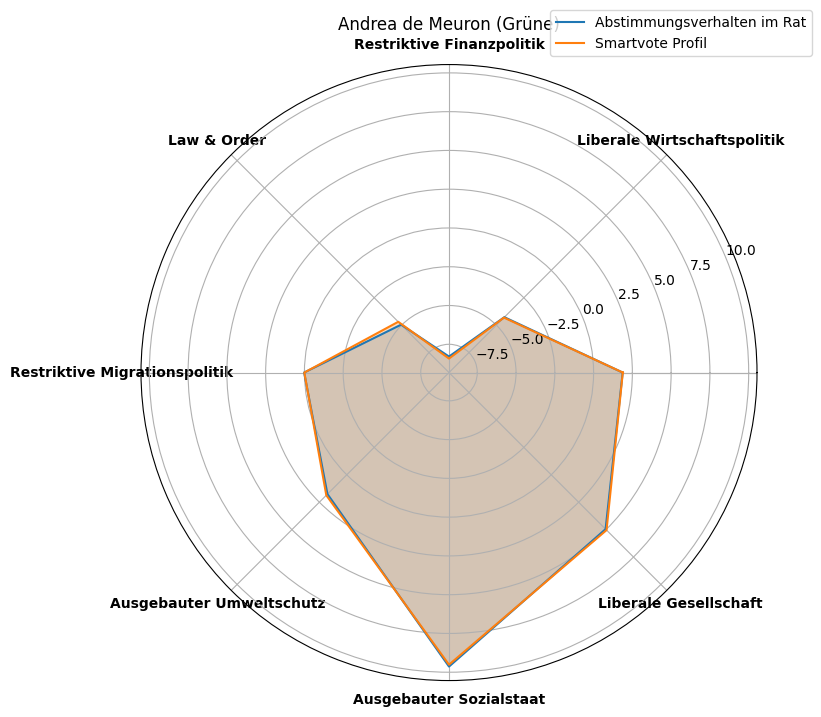

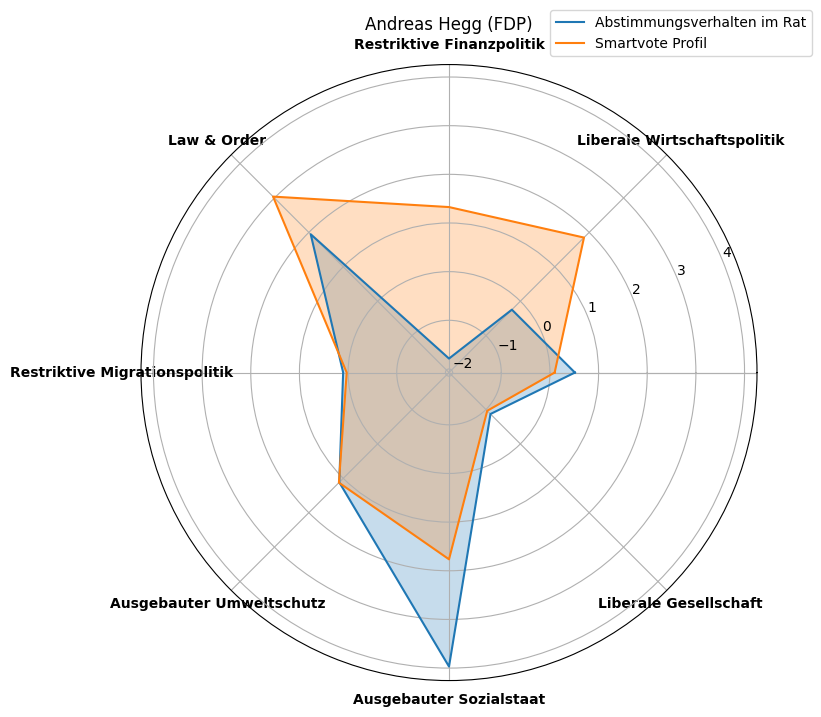

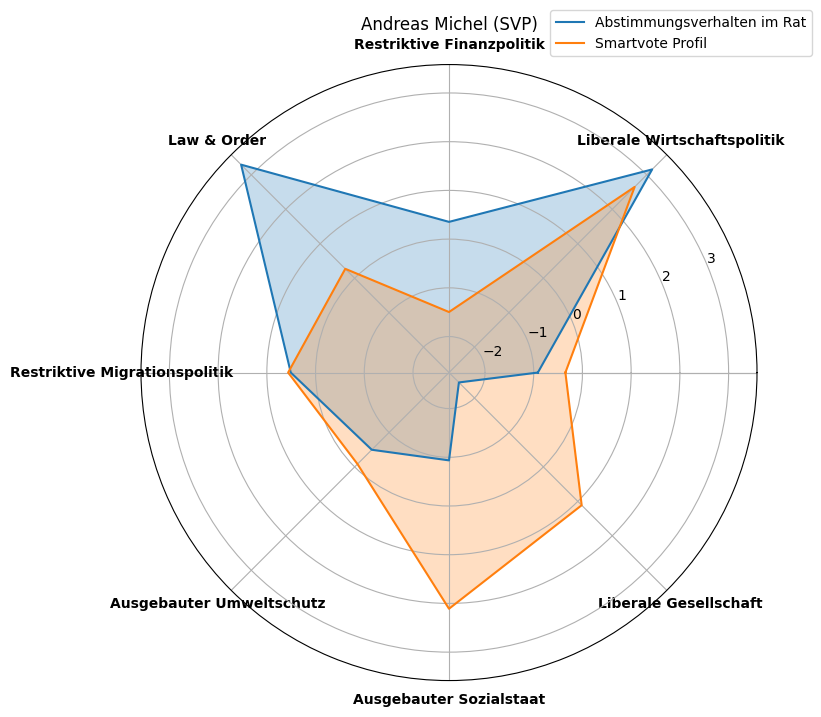

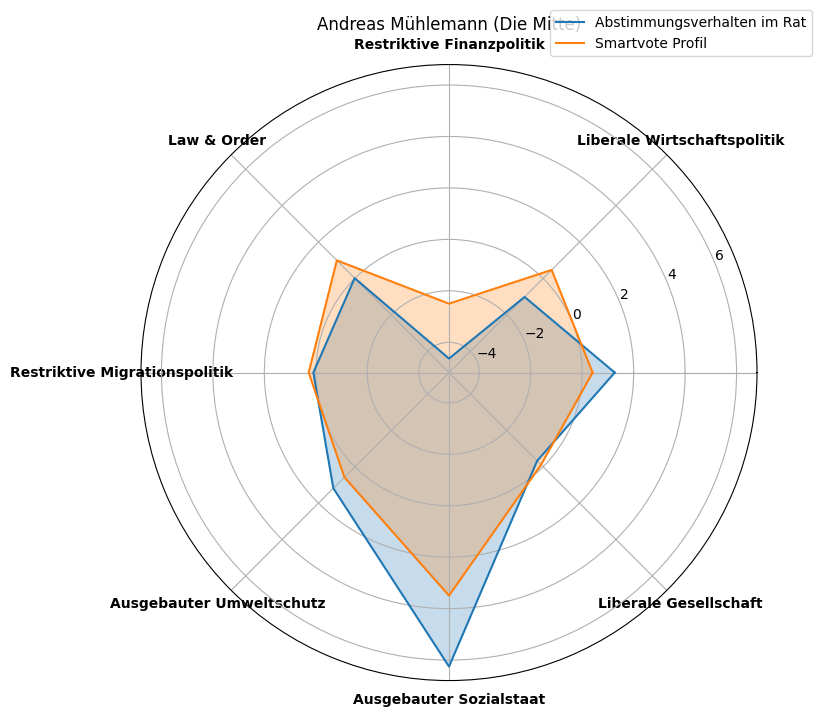

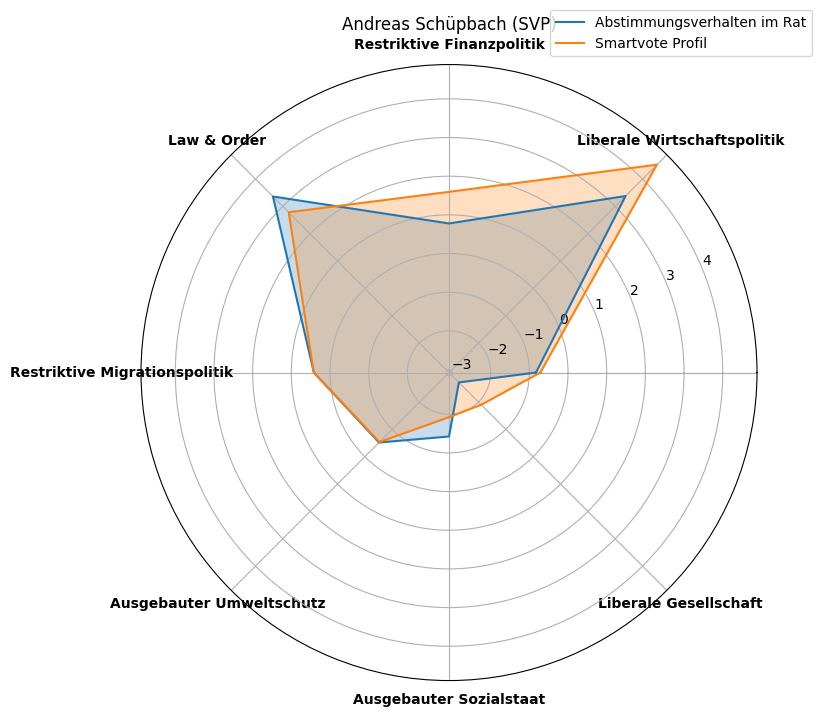

In [8]:
v = to_smartvote_spider(votes).detach().numpy()
sv = to_smartvote_spider(smartvote).detach().numpy()

#TODO verify the rows correspond to the same person in all the csvs
from random import randint
#for index in range(len(sv[0])):#Uncomment this line (and comment out the next) if you want to plot all of the data
for index in range(x:=randint(0, len(sv[0])), x+5):
    plot_two_spider_charts(v[:, index], sv[:, index], f"{df_votes['first_name'][index]} {df_votes['last_name'][index]} ({df_smartvote['partyAbbreviation'][index]})")